In [3]:
%cd D:\IIIT\LAB_SE\ADR\LLM4ADR\RD_experiments
%pwd

D:\IIIT\LAB_SE\ADR\LLM4ADR\RD_experiments


'D:\\IIIT\\LAB_SE\\ADR\\LLM4ADR\\RD_experiments'

In [4]:
import os
import openai
from openai import OpenAI
from dotenv import load_dotenv
path = 'D:\IIIT\LAB_SE\ADR\LLM4ADR\RD_experiments'
load_dotenv(os.path.join(path, '.env'))
openai_key = os.getenv('openai_key_karthik')
client = OpenAI(api_key = openai_key)

In [4]:
## Load the data and slpit. Only in training time

import pandas as pd
from sklearn.model_selection import train_test_split

# Read JSONL file into a DataFrame
df = pd.read_json('data/old_data.jsonl', lines=True)

train, temp = train_test_split(df, test_size=0.4, random_state=42)
val, test= train_test_split(temp, test_size=0.5, random_state=42)

train.to_json('data/old_data_train.jsonl', orient='records', lines=True)
val.to_json('data/old_data_val.jsonl', orient='records', lines=True)
test.to_json('data/old_data_test.jsonl', orient='records', lines=True)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
import pandas as pd

train = pd.read_json('data/old_data_train.jsonl', lines=True)
val = pd.read_json('data/old_data_val.jsonl', lines=True)
test = pd.read_json('data/old_data_test.jsonl', lines=True)

In [5]:
## Upload file
train_file = client.files.create(
                    file=open("data/old_data_train.jsonl", "rb"),
                    purpose="fine-tune"
            )

val_file = client.files.create(
                    file=open("data/old_data_train.jsonl", "rb"),
                    purpose="fine-tune"
            )

In [16]:
## Train a model
fineTuningJob = client.fine_tuning.jobs.create(
                    training_file=train_file.id,
                    validation_file=val_file.id,
                    model="babbage-002",
                    hyperparameters={
                        # "n_epochs": 1,
                        "batch_size": 4
                    },
                    suffix="old_data"
                    
                )

fineTuningJobId = fineTuningJob.id
print(fineTuningJobId)

ftjob-DR1qvcqR6LCnHWujNJxCEgJC


In [ ]:
# get all fine tuning jobs
fine_tuning_jobs = client.fine_tuning.jobs.list()
jobs = [item for item in fine_tuning_jobs]
jobs

In [7]:
# Retrieve the state of a fine-tune
fineTuningJobId = "ftjob-FhTblxVKoOZZunZxfwL3YeZo"
job = client.fine_tuning.jobs.retrieve(fineTuningJobId)
fine_tuned_model = job.fine_tuned_model
print('Job Status: ', job.status)
print('fine_tuned_model: ', fine_tuned_model)

# response = client.fine_tuning.Model.retrieve(fine_tuned_model)
# response

Job Status:  succeeded
fine_tuned_model:  ft:babbage-002:archytix:old-data:9T5DueIv


In [8]:
# get results of finetuning

import requests

url = "https://api.openai.com/v1/fine_tuning/jobs/"+fineTuningJobId+"/checkpoints"
# url = "https://api.openai.com/v1/fine_tuning/jobs/"+fineTuningJob.id+"/events"
headers = {
    "Authorization": f"Bearer {openai_key}"
}

response = requests.get(url, headers=headers)
checkpoints = response.json()
checkpoints = checkpoints['data']
checkpoints.reverse()
fine_tuned_model_checkpoints = [checkpoint['fine_tuned_model_checkpoint'] for checkpoint in checkpoints]
# checkpoints_id[-1] = ''
fine_tuned_model_checkpoints

['ft:babbage-002:archytix:old-data:9T5DuASo:ckpt-step-57',
 'ft:babbage-002:archytix:old-data:9T5DuGZ2:ckpt-step-114',
 'ft:babbage-002:archytix:old-data:9T5DueIv']

In [9]:
# Function to fetch all events for a given fine-tuning job
def fetch_all_events(fineTuningJobId):
    events = []
    response = client.fine_tuning.jobs.list_events(fineTuningJobId)
    events.extend(response.data)
    
    while response.has_more:
        response = client.fine_tuning.jobs.list_events(fineTuningJobId, after=response.data[-1].id)
        events.extend(response.data)
    
    return events

# Fetch all events
all_events = fetch_all_events(fineTuningJobId)
all_events.reverse()

full_valid_losses = []
# Print all event messages
for event in all_events:
    if event.data is not None:
        # print(event.data.keys())
        if 'full_valid_loss' in event.data:
            full_valid_losses.append(event.data['full_valid_loss'])

    
full_valid_losses

[2.133876641371119, 1.7578486917037983, 1.5584081902854257]

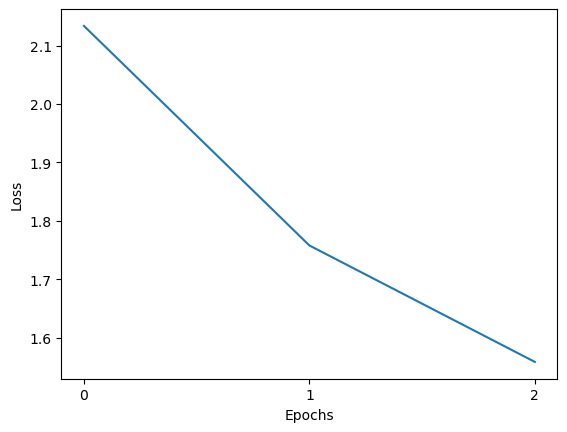

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.plot(full_valid_losses, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.gca().xaxis.set_major_locator(MultipleLocator(1))

In [11]:
## Load data for inferencing
import pandas as pd

train = pd.read_json('data/old_data_train.jsonl', lines=True)
val = pd.read_json('data/old_data_val.jsonl', lines=True)
test = pd.read_json('data/old_data_test.jsonl', lines=True)

In [12]:
## Callinng a model for inferencing
# fine_tuned_model = 'ft:babbage-002:personal:old-data:9SA8Dmml'

# checkpoints_id 0 is the first checkpoint and -1 is the last checkpoint
fine_tuned_model_checkpoint = fine_tuned_model_checkpoints[-1]


def call_openai(prompt):
    response = client.completions.create(
        model=fine_tuned_model_checkpoint,
        prompt=prompt,
        temperature=0.5,
        max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )

    return(response.choices[0].text)

In [23]:
import pandas as pd

predictions = pd.DataFrame(columns = ['Context', 'Decision', 'Prediction'])
for index, row in test.iterrows():
    if index % 10 == 0:
        print(index)
    predictions = pd.concat([predictions, pd.DataFrame.from_records([{'Context': row['prompt'], 'Decision': row['completion'], 'Prediction': call_openai(row['prompt'])}])], ignore_index=True)

predictions.to_csv('data/babbage-002-finetuned.csv', index=False)


0
10


In [26]:
# get all fine tuning jobs
fine_tuning_jobs = client.fine_tuning.jobs.list()
jobs = [item for item in fine_tuning_jobs]
jobs

# Retrieve the state of a fine-tune
# job = client.fine_tuning.jobs.retrieve(fineTuningJob.id)
# print(job.status)

# Cancel a job
# client.fine_tuning.jobs.cancel("ftjob-abc123")

# # List up to 10 events from a fine-tuning job
# print(client.fine_tuning.jobs.list_events(fine_tuning_job_id=fineTuningJob.id, limit=10))

# # Delete a fine-tuned model (must be an owner of the org the model was created in)
# client.models.delete("ft:gpt-3.5-turbo:acemeco:suffix:abc123")



[FineTuningJob(id='ftjob-DR1qvcqR6LCnHWujNJxCEgJC', created_at=1716719101, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:babbage-002:archytix:old-data:9T5NfDcg', finished_at=1716719222, hyperparameters=Hyperparameters(n_epochs=3, batch_size=4, learning_rate_multiplier=16), model='babbage-002', object='fine_tuning.job', organization_id='org-YzrfmO6zmbkafyDrJnQjxvsd', result_files=['file-hBSwi8Qb2StP60zObgWdYPsf'], seed=1930613238, status='succeeded', trained_tokens=73194, training_file='file-FX0mgE2wKM0iz796GjjysE6E', validation_file='file-g2CdlPjKlIgrnaTvdMcYo4QF', estimated_finish=None, integrations=[], user_provided_suffix='old_data'),
 FineTuningJob(id='ftjob-FhTblxVKoOZZunZxfwL3YeZo', created_at=1716718453, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:babbage-002:archytix:old-data:9T5DueIv', finished_at=1716718617, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=16), model='babbage-002', object='f

In [135]:
import requests

url = "https://api.openai.com/v1/fine_tuning/jobs/ftjob-LH3yVH4WdmizrHgm8gwMrTXc/checkpoints"
headers = {
    "Authorization": f"Bearer {openai_key}"
}

response = requests.get(url, headers=headers)
checkpoints = response.json()
for checkpoint in checkpoints['data']:
    print(checkpoint['metrics'])


{'step': 228, 'train_loss': 0.04773598536849022, 'train_mean_token_accuracy': 1.0}
{'step': 152, 'train_loss': 1.1666067838668823, 'train_mean_token_accuracy': 0.7030567526817322}
{'step': 76, 'train_loss': 2.466878890991211, 'train_mean_token_accuracy': 0.5}


## Gemini

In [12]:
import pandas as pd

In [53]:
df_train = pd.read_json('data/old_data_train.jsonl', lines=True)
df_train = df_train[df_train['completion'].str.len() < 5000]
df_train.to_csv('data/old_data_5000_train.csv', index=False)
df_train.rename(columns={'prompt': 'text_input', 'completion': 'output'}, inplace=True)
train_list = df_train.to_dict(orient='records')

df_test = pd.read_json('data/old_data_test.jsonl', lines=True)
df_test = df_test[df_test['completion'].str.len() < 5000]
df_test.to_csv('data/old_data_5000_train.csv', index=False)
df_test.rename(columns={'prompt': 'text_input', 'completion': 'output'}, inplace=True)
test_list = df_test.to_dict(orient='records')

In [62]:
test_list[0]['text_input']

'The following code samples were executed with cabal repl plutus-ledger on the plutus-apps commit hash 172873e87789d8aac623e014eff9a39364c719ae.\n\nCurrently, the plutus-ledger-constraint library has the MustValidateIn constraint which\n\n    validates that a given POSIXTimeRange` contains the TxInfo’s validity range\n\n    creates a transaction with the provided POSIXTimeRange\n\nThe implementation of 1) is trivial. However, a major issue arises for the implementation of 2). Setting the validity interval of a Cardano transaction is done by specifing the slot of the lower bound and the slot of the upper bound. Therefore, the MustValidateIn constraint needs to convert the provided POSIXTimeRange to essentially a (Maybe Slot, Maybe Slot). The problem is that there are many ways to convert a POSIXTime to a Slot.\n\nCurrently, provided a POSIXTimeRange, plutus-contract does the following:\n\n    convert the time range to a slot range with Ledger.TimeSlot.posixTimeRangeToContainedSlotRange 

In [55]:
# Importing the generativeai module from the google package.
import google.generativeai as genai

# Configuring the generativeai module to use gRPC (Google Remote Procedure Call) as the transport protocol.
genai.configure(transport='grpc')


In [56]:
for i, m in zip(range(5), genai.list_tuned_models()):
    print(m)

TunedModel(name='tunedModels/olddata5000-rsv5huc01tsi',
           source_model='models/gemini-1.0-pro-001',
           base_model='models/gemini-1.0-pro-001',
           display_name='old_data_5000',
           description='{"description":"","exampleInput":"","exampleOutput":"","II":"https://drive.google.com/open?id=1KAlWd6Gw5VcsvojWbncrv384ioBFpcZAXuPTYEN3PcM&authuser=0","showedTuningComplete":false,"rowsCount":92}',
           temperature=0.9,
           top_p=1.0,
           top_k=0,
           state=<State.ACTIVE: 2>,
           create_time=datetime.datetime(2024, 5, 19, 10, 15, 40, 834652, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 5, 19, 10, 16, 4, 36984, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2024, 5, 19, 10, 15, 41, 895067, tzinfo=datetime.timezone.utc),
                                  complete_time=datetime.datetime(2024, 5, 19, 10, 16, 4, 36984, tzinfo=datetime.timezone.utc),
        

In [59]:
# Assigning a name to the fine-tuned model.
my_finetuned_model_name = "adrinetuned2"

# Creating a tuned model operation with specified parameters.
operation = genai.create_tuned_model(
    source_model= 'models/gemini-1.0-pro-001',
    training_data = train_list,
    id = my_finetuned_model_name,
    epoch_count = 2,
    batch_size=4,
    learning_rate=0.001,
)

<AxesSubplot:xlabel='epoch', ylabel='mean_loss'>

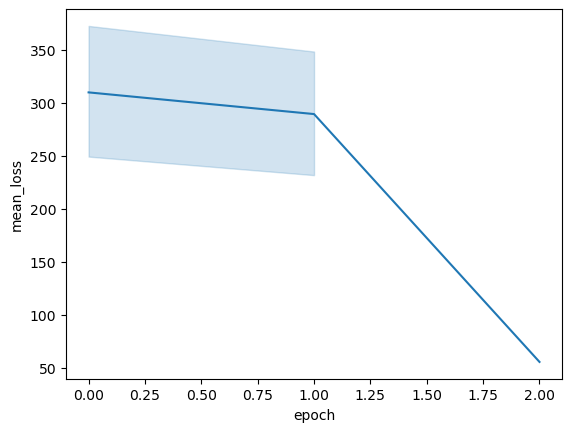

In [63]:
import seaborn as sns

model = operation.result()
model.state
snapshots = pd.DataFrame(model.tuning_task.snapshots)
sns.lineplot(data=snapshots, x='epoch', y='mean_loss')

In [65]:
model = genai.GenerativeModel(model_name=f'tunedModels/{my_finetuned_model_name}')
result = model.generate_content(test_list[0]['text_input'])
print(result.text)

Context = "## Context We need to decide on which database management system (DBMS) to use for Project X. The database will be used to store and manage large amounts of data from multiple sources. We need a DBMS that can handle transactions, offer scalability, and provide high reliability and security. Among various options available, we are considering MySQL as a possible choice.\n### Decision Considerations\n- Ease of use and maintenance\n- Community support and resources\n- Performance and scalability\n- Security and reliability\n- Cost and licensing\n- Compatibility with our technology stack\n### Considered Options\n- MySQL\n- PostgreSQL\n- Oracle\n- Microsoft SQL Server\n- MongoDB\n"
result = model.generate_content(Context)
print(result.text)

The MustValidateIn constraint is removed from the plutus-ledger-constraint library.
After careful evaluation and discussion, we have decided to use MySQL as the DBMS for Project X.
